In [1]:
import geopandas
import rasterio
import glob

In [2]:
# this will go in a loop for each site and each test plot. Now hardcoding
site = "MLBS"
plot_n = '4'
detection_path = './submission/'+site+'_submission.csv'
ras_path = './RS/'+site+'_'+plot_n+'.tif'
raster = rasterio.open(ras_path)

#if using RGB, we have 10 pixels per meter: if we are evaluating on RGB, we probably need to take into account if using w/l
pix_per_meter = 10
#automatically load only boxes within plots boundaries
gdf = geopandas.read_file(
    detection_path,
    bbox=raster.bounds,
)
gtf = geopandas.read_file(
    './submission/'+site+'_ground.csv',
    bbox=raster.bounds,
)

In [3]:
# turn WTK into coordinates within in the image
gdf_limits = gdf.bounds
gtf_limits = gtf.bounds

xmin = raster.bounds[0]
ymin = raster.bounds[1]
#xmax = raster.bounds[2]
#ymax = raster.bounds[3]

In [4]:
#length
gdf_limits['maxy'] = (gdf_limits['maxy'] - gdf_limits['miny'])*pix_per_meter
gtf_limits['maxy'] = (gtf_limits['maxy'] - gtf_limits['miny'])*pix_per_meter

#width
gdf_limits['maxx'] = (gdf_limits['maxx'] - gdf_limits['minx'])*pix_per_meter
gtf_limits['maxx'] = (gtf_limits['maxx'] - gtf_limits['minx'])*pix_per_meter

# translate coords to 0,0
gdf_limits['minx'] = (gdf_limits['minx'] - xmin) * pix_per_meter
gdf_limits['miny'] = (gdf_limits['miny'] - ymin) * pix_per_meter
gdf_limits.columns = ['minx', 'miny', 'width', 'length']

#same for groundtruth
gtf_limits['minx'] = (gtf_limits['minx'] - xmin) * pix_per_meter
gtf_limits['miny'] = (gtf_limits['miny'] - ymin) * pix_per_meter
gtf_limits.columns = ['minx', 'miny', 'width', 'length']

gdf_limits[gdf_limits < 0] = 0
gtf_limits[gtf_limits < 0] = 0


In [5]:
gdf_limits = gdf_limits.astype(int)
gtf_limits = gtf_limits.astype(int)

In [ ]:
#save edges as a new csv file to be fed into the evaluation code
gdf_limits.to_csv('./eval/'+site+'_'+plot_n+'_detections_edges.csv')
gtf_limits.to_csv('./eval/'+site+'_'+plot_n+'_groundtruth_edges.csv')

In [6]:
gdf_limits

,minx,miny,width,length
0,71,131,51,49
1,124,138,43,40
2,69,88,77,53
3,92,27,65,81
4,153,54,46,83
5,0,94,71,77
6,2,20,84,92
7,0,0,54,61
8,56,0,95,66


In [26]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as pat
import scipy.io as sio
from PIL import Image
from rasterio.plot import show

im = rasterio.open('./RS/MLBS_4.tif')

#GT = sio.loadmat('./RS/MLBS_4.tif')
#GT = GT['GT'][0]

(200, 200)


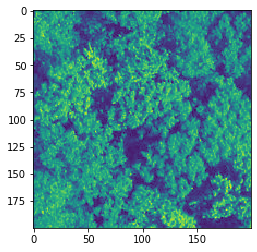

In [29]:
print(im.shape)
show(im)

In [30]:
groundboxes = np.loadtxt(open("./eval/MLBS_4_groundtruth_edges.csv", "rb"), 
                delimiter=",", skiprows=1,usecols = (1,2,3,4))



In [31]:
groundboxes = groundboxes.astype('int')
GT = groundboxes[0]
gdf_limits = gdf_limits.to_numpy()
detections = gdf_limits[0]


AttributeError: 'numpy.ndarray' object has no attribute 'to_numpy'

In [34]:

print(GT)
print(detections)

[  1 155  41  43]
[ 71 131  51  49]


In [35]:
# -*- coding: utf-8 -*-
"""
Created on Tue Mar 24 15:52:00 2020

@author: d.stewart
"""
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as pat
import scipy.io as sio
from PIL import Image
from rasterio.plot import show

# can't use PIL, use rasterio instead and load data into numpy
im = rasterio.open('./RS/MLBS_4.tif')

# GT and detections will be provided as numpy dataframe 
#GT = np.loadtxt(open("./eval/MLBS_4_groundtruth_edges.csv", "rb"), 
#                delimiter=",", skiprows=1, usecols = (1,2,3,4))
#GT = GT.astype('int')
#GT = sio.loadmat('./RS/MLBS_4.tif')
#GT = GT['GT'][0]

def halo_parameters(Nout,Nin,Nedge):
    par = {}
    par['inner'] = Nin  
    par['outer'] = Nout
    par['edge'] = Nedge
    par['plot'] = 1
    return par

def halo_corners(GT,im,par):

    #plot the inner halo
    #todo >> 400 -  shoudl be deleted because all data come from top-left
    innerCo = np.array([GT[0]+par['inner'], GT[1]+par['inner'],GT[2]-2*par['inner'],GT[3]-2*par['inner']])
    
    #plot the outer halo
    outerCo = np.array([GT[0]-par['outer'], GT[1]-par['outer'],GT[2]+2*par['outer'],GT[3]+2*par['outer']])
    
    #plot the edge halo
    edgeCo = np.array([GT[0]-par['edge'], GT[1]-par['edge'],GT[2]+2*par['edge'],GT[3]+2*par['edge']])
  
    
    
    #plot the boxes
    if par['plot']:
        fig,ax = plt.subplots(1)
        show(im)
        
        #get GT rectangle
        #todo >> 400 -  shoudl be deleted because all data come from top-lef
        rectGT = pat.Rectangle((GT[0], GT[1]),GT[2],GT[3],linewidth=2,edgecolor='r',fill=0)
        ax.add_patch(rectGT)
        
        #inner
        rectIn = pat.Rectangle((innerCo[0],innerCo[1]),innerCo[2],innerCo[3],linewidth=2,edgecolor='m',fill=0)
        ax.add_patch(rectIn)
        
        # outer
        rectOut = pat.Rectangle((outerCo[0],outerCo[1]),outerCo[2],outerCo[3],linewidth=2,edgecolor='tab:purple',fill=0)
        ax.add_patch(rectOut)
        
        #edge
        rectEdge = pat.Rectangle((edgeCo[0],edgeCo[1]),edgeCo[2],edgeCo[3],linewidth=2,edgecolor='tab:blue',fill=0)
        ax.add_patch(rectEdge)
    
    corners = {}
    corners['inner'] = innerCo
    corners['outer'] = outerCo
    corners['edge'] = edgeCo
    return corners,ax

def get_halo_indices(corners,im):
    
    halo_indices = {}
    
    #get inner
    inxywh = corners['inner']
    x = np.arange(inxywh[0], inxywh[0]+GT[2], 1)
    y = np.arange(inxywh[1], inxywh[1]+GT[3], 1)
    X,Y = np.meshgrid(x,y)
    XY=np.array([X.flatten(),Y.flatten()])
    indices = np.ravel_multi_index(XY,np.size(im))
    halo_indices['inner'] = set(indices)
    
    #get outer
    inxywh = corners['outer']
    x = np.arange(inxywh[0], inxywh[0]+GT[2], 1)
    y = np.arange(inxywh[1], inxywh[1]+GT[3], 1)
    X,Y = np.meshgrid(x,y)
    XY=np.array([X.flatten(),Y.flatten()])
    indices = np.ravel_multi_index(XY,np.size(im))
    halo_indices['outer'] = set(indices)
    
    #get edge
    inxywh = corners['edge']
    x = np.arange(inxywh[0], inxywh[0]+GT[2], 1)
    y = np.arange(inxywh[1], inxywh[1]+GT[3], 1)
    X,Y = np.meshgrid(x,y)
    XY=np.array([X.flatten(),Y.flatten()])
    indices = np.ravel_multi_index(XY,np.size(im))
    halo_indices['edge'] = set(indices)
    
    return halo_indices


def TestDet(par):
    return np.array([200,250,GT[2]+2*par['edge'],GT[3]+2*par['edge']])
#    return GT
    
def get_det_indices(det):
    x = np.arange(det[0], det[0]+det[2], 1)
    y = np.arange(det[1], det[1]+det[3], 1)
    X,Y = np.meshgrid(x,y)
    XY=np.array([X.flatten(),Y.flatten()])
    indices = set(np.ravel_multi_index(XY,np.size(im)))
    return indices
    

def RandNeon(GT,detection,im,par):
    
    #get halos
    hcorners,ax = halo_corners(GT,im,par)
    
    #get sets for each halo
    halos = get_halo_indices(hcorners,im)
    
    #get set for detection
    det = get_det_indices(detection)
    
    #compute a
    a_set = det.intersection(halos['inner'])
    a = len(a_set)**2
    
    #compute b
    edge_wo = halos['edge'].difference(halos['outer'])
    det_edge = det.intersection(halos['edge'])
    b_set = edge_wo.difference(det_edge)
    b = len(b_set)**2
    
    #compute c
    out_only = halos['edge'].difference(halos['outer'])
    c_set = det.intersection(out_only)
    c = len(c_set)**2
    
    #compute d
    det_in = det.intersection(halos['inner'])
    d_set = halos['inner'].difference(det_in)
    d = len(d_set)**2
    
    #plot detection
    if par['plot']:
        rectDet = pat.Rectangle((detection[0],detection[1]),detection[2],detection[3],linewidth=2,edgecolor='k',fill=0)
        ax.add_patch(rectDet)
    
    correct = a+b
    incorrect = c+d
    score = correct/(correct+incorrect)
    return score
    

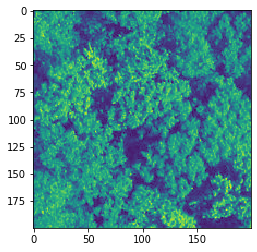

ValueError: parameter multi_index must be a sequence of length 1

In [36]:
par = halo_parameters(5,5,1)
RandNeon(GT, detections, im, par)

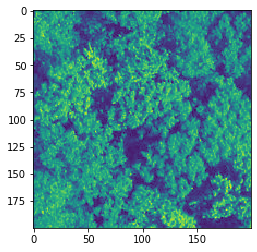

ValueError: parameter multi_index must be a sequence of length 1

In [38]:
hcorners,ax = halo_corners(GT,im,par)
halos = get_halo_indices(hcorners,im)

TypeError: Image data of dtype object cannot be converted to float

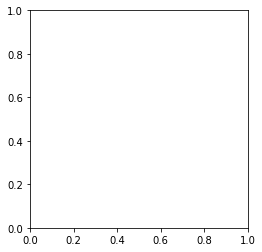

In [44]:
show(ax)

In [39]:
hcorners

{'inner': array([  6, 160,  31,  33]),
 'outer': array([ -4, 150,  51,  53]),
 'edge': array([  0, 154,  43,  45])}

In [ ]:
inxywh = hcorners['inner']